In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.fftpack import dct

In [2]:
data_dir = r"M:\neuro2voc\task-5"
spectrogram_path = r"M:\neuro2voc\task-5\frequencies.spec.npy"
spec_dir = r"M:\neuro2voc\task-5\dtw\spectrogram"
mfcc_dir = r"M:\neuro2voc\task-5\dtw\MFCC"
embeddings_dir = r"M:\neuro2voc\task-5\dtw\embeddings"
dtw_mfcc_dir = r"M:\neuro2voc\task-5\dtw\MFCC-dtw"

In [8]:
raw_frequencies = np.load(spectrogram_path)
frequencies = raw_frequencies[0]

spec_0 = np.load(f'{data_dir}\\raw_g0_t0.nidq.bin.spec.npy')
spec_1 = np.load(f'{data_dir}\\raw_g1_t0.nidq.bin.spec.npy')
spec_2 = np.load(f'{data_dir}\\raw_g2_t0.nidq.bin.spec.npy')
print(f"Original spec_0 shape: {spec_0.shape}")

padding = 4  # 16ms * 250Hz = 40 samples
padded_spec_0 = np.pad(spec_0, ((0, 0), (padding, 0)), mode='constant')
padded_spec_1 = np.pad(spec_1, ((0, 0), (padding, 0)), mode='constant')
padded_spec_2 = np.pad(spec_2, ((0, 0), (padding, 0)), mode='constant')
print(f"Padded spec_0 shape: {padded_spec_0.shape}")


Original spec_0 shape: (128, 799311)
Padded spec_0 shape: (128, 799315)


In [9]:
len(frequencies)
print(frequencies)

[   0.           62.99212598  125.98425197  188.97637795  251.96850394
  314.96062992  377.95275591  440.94488189  503.93700787  566.92913386
  629.92125984  692.91338583  755.90551181  818.8976378   881.88976378
  944.88188976 1007.87401575 1070.86614173 1133.85826772 1196.8503937
 1259.84251969 1322.83464567 1385.82677165 1448.81889764 1511.81102362
 1574.80314961 1637.79527559 1700.78740157 1763.77952756 1826.77165354
 1889.76377953 1952.75590551 2015.7480315  2078.74015748 2141.73228346
 2204.72440945 2267.71653543 2330.70866142 2393.7007874  2456.69291339
 2519.68503937 2582.67716535 2645.66929134 2708.66141732 2771.65354331
 2834.64566929 2897.63779528 2960.62992126 3023.62204724 3086.61417323
 3149.60629921 3212.5984252  3275.59055118 3338.58267717 3401.57480315
 3464.56692913 3527.55905512 3590.5511811  3653.54330709 3716.53543307
 3779.52755906 3842.51968504 3905.51181102 3968.50393701 4031.49606299
 4094.48818898 4157.48031496 4220.47244094 4283.46456693 4346.45669291
 4409.4

In [10]:
annotations_df_0 = pd.read_csv(f'{data_dir}\\annotations_raw_g0_t0.nidq.bin.csv')
annotations_df_0['onset_sec'] = annotations_df_0['onset'] / 20000
annotations_df_0['duration_sec'] = annotations_df_0['duration'] / 20000
filtered_df_0 = annotations_df_0[annotations_df_0['cluster_id'].between(2, 8)]

annotations_df_1 = pd.read_csv(f'{data_dir}\\annotations_raw_g1_t0.nidq.bin.csv')
annotations_df_1['onset_sec'] = annotations_df_1['onset'] / 20000
annotations_df_1['duration_sec'] = annotations_df_1['duration'] / 20000
filtered_df_1 = annotations_df_1[annotations_df_1['cluster_id'].between(2, 8)]

annotations_df_2 = pd.read_csv(f'{data_dir}\\annotations_raw_g2_t0.nidq.bin.csv')
annotations_df_2['onset_sec'] = annotations_df_2['onset'] / 20000
annotations_df_2['duration_sec'] = annotations_df_2['duration'] / 20000
filtered_df_2 = annotations_df_2[annotations_df_2['cluster_id'].between(2, 8)]

In [11]:
i = 0
for spec_data in [spec_0, spec_1, spec_2]:
    duration = spec_data.shape[1] / (250*60)
    print(f"File raw_g{i}_t0.nidq.bin.spec.npy duration: {duration:.2f} minutes")

    spike_times = np.load(f'{data_dir}\\spiketimes_raw_g{i}_t0.nidq.bin.npy')[0]
    duration = spike_times.max() / (20000*60)
    print(f"File spiketimes_raw_g{i}_t0.nidq.bin.npy duration: {duration:.2f} minutes")
    
    i += 1

File raw_g0_t0.nidq.bin.spec.npy duration: 53.29 minutes
File spiketimes_raw_g0_t0.nidq.bin.npy duration: 53.29 minutes
File raw_g1_t0.nidq.bin.spec.npy duration: 90.06 minutes
File spiketimes_raw_g1_t0.nidq.bin.npy duration: 89.91 minutes
File raw_g2_t0.nidq.bin.spec.npy duration: 77.90 minutes
File spiketimes_raw_g2_t0.nidq.bin.npy duration: 70.37 minutes


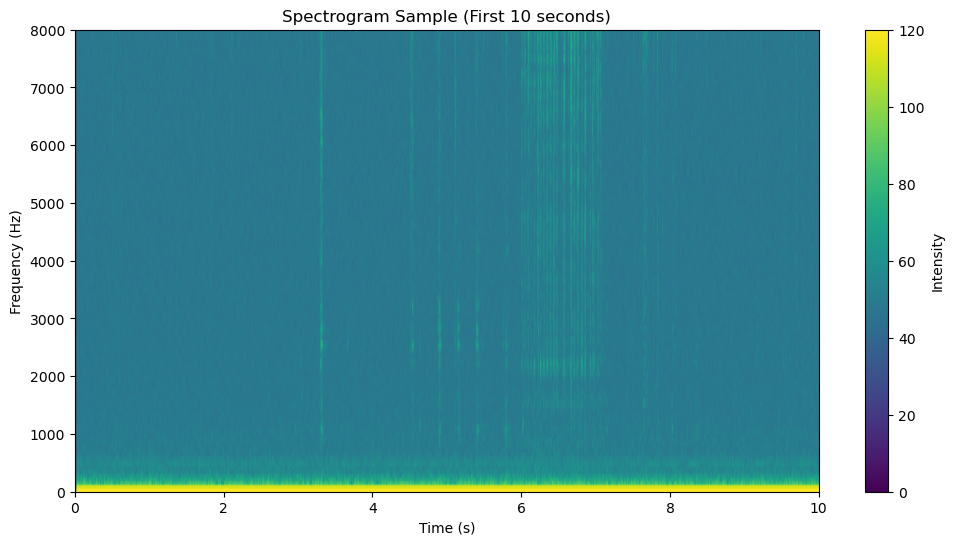

Spectrogram sample plot saved as 'spectrogram_sample.png'


In [12]:
sample_duration = 10  # s
sample_data = padded_spec_2[:, :sample_duration*250]

plt.figure(figsize=(12, 6))

if len(frequencies) >= 2:
    freq_min, freq_max = frequencies[0], frequencies[-1]
else:
    print("Warning: Not enough frequency data. Using default values.")
    freq_min, freq_max = 0, 1000

try:
    plt.imshow(sample_data, aspect='auto', origin='lower', 
               extent=[0, sample_duration, freq_min, freq_max])
    plt.colorbar(label='Intensity')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title(f'Spectrogram Sample (First {sample_duration} seconds)')
    # plt.savefig('/home/askr/Projects/neuro2voc/task-5/spectrogram_sample.png')
    plt.show()
    print(f"Spectrogram sample plot saved as 'spectrogram_sample.png'")
except Exception as e:
    print(f"Error plotting spectrogram: {e}")
    print(f"Sample data shape: {sample_data.shape}")
    print(f"Extent values: [0, {sample_duration}, {freq_min}, {freq_max}]")

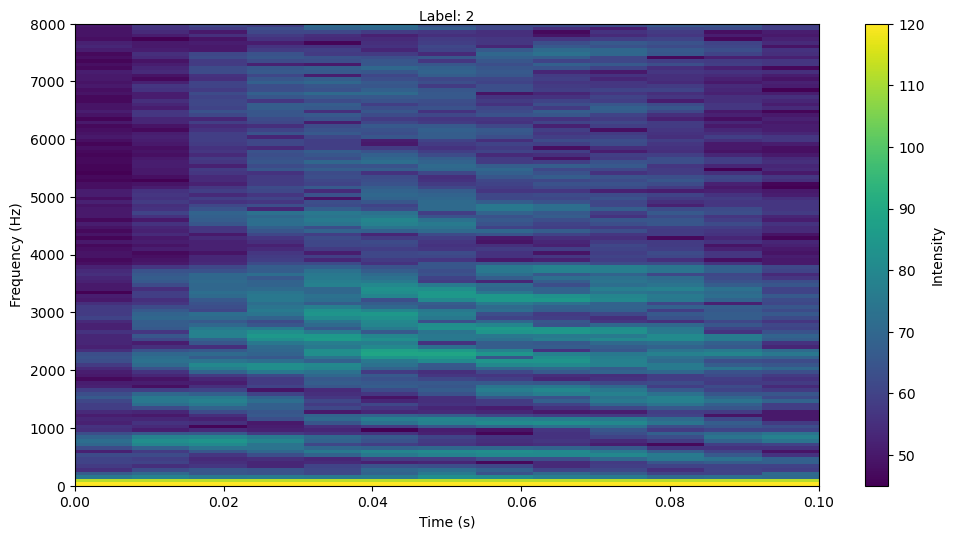

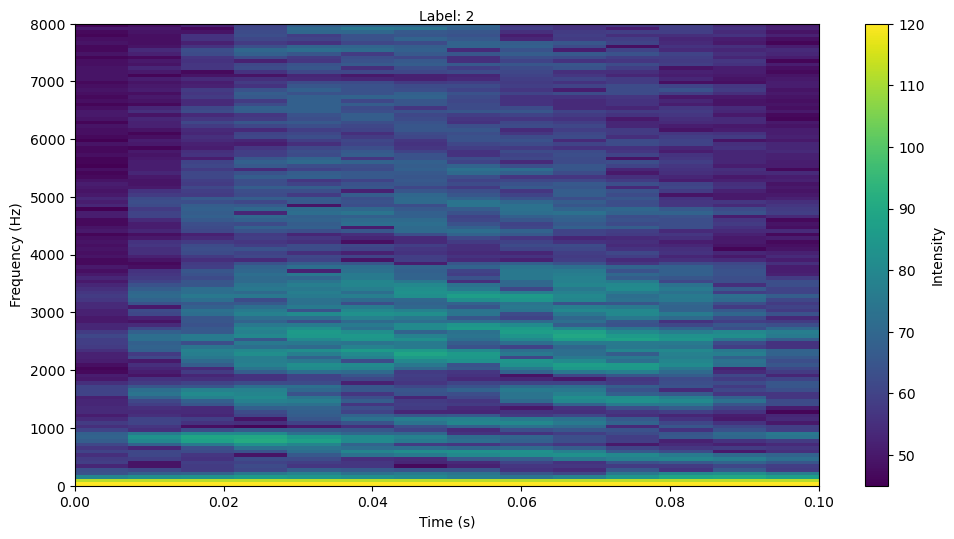

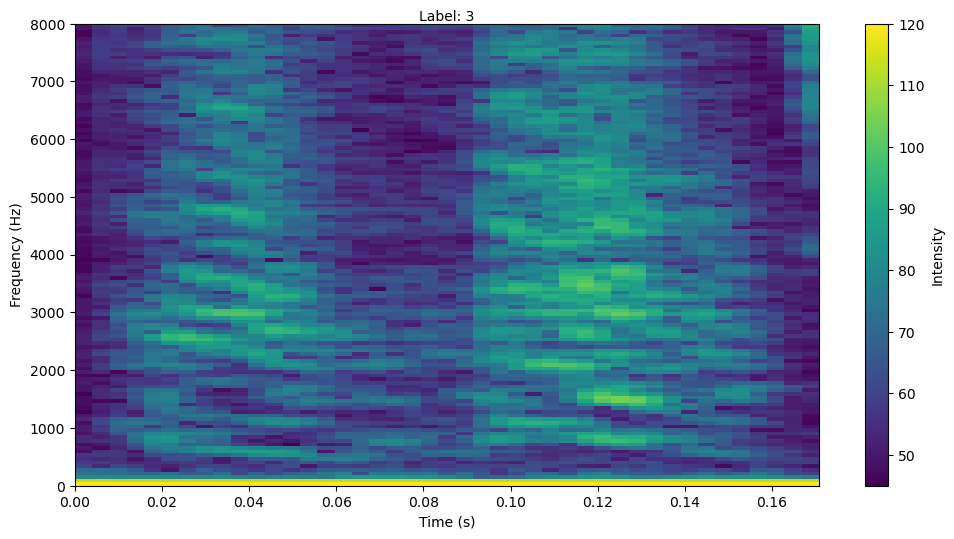

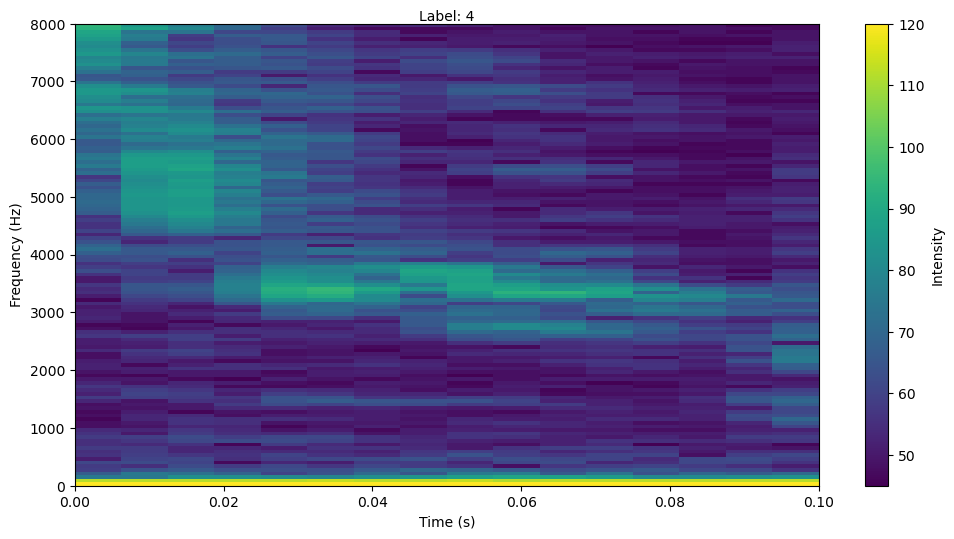

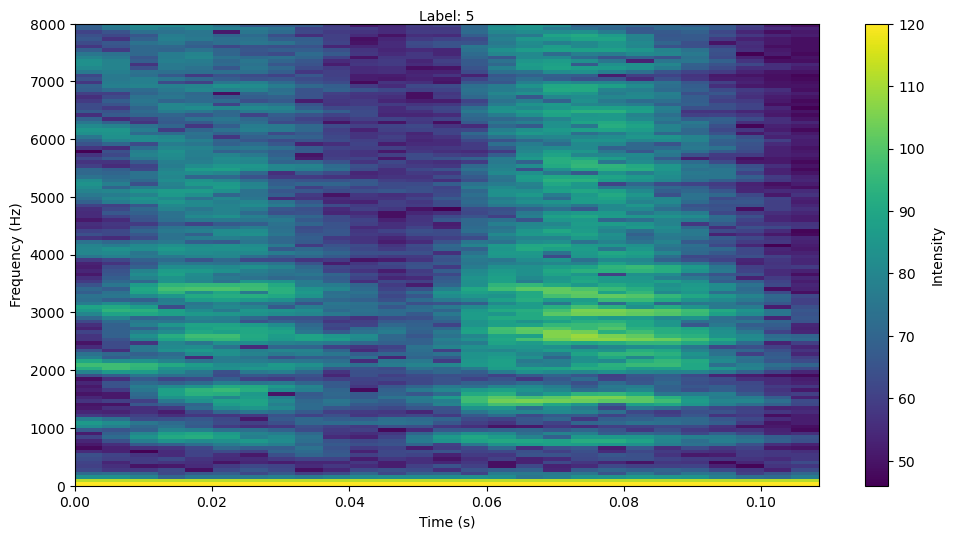

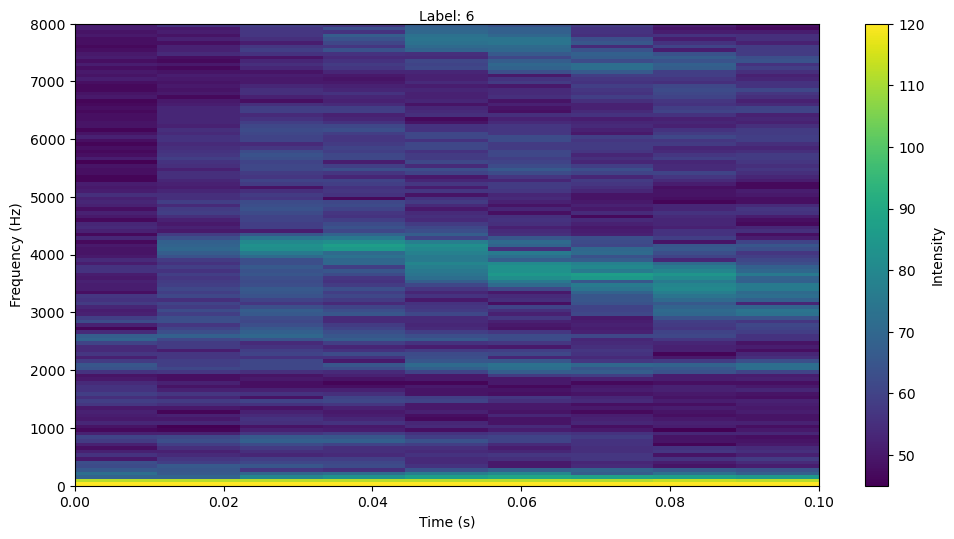

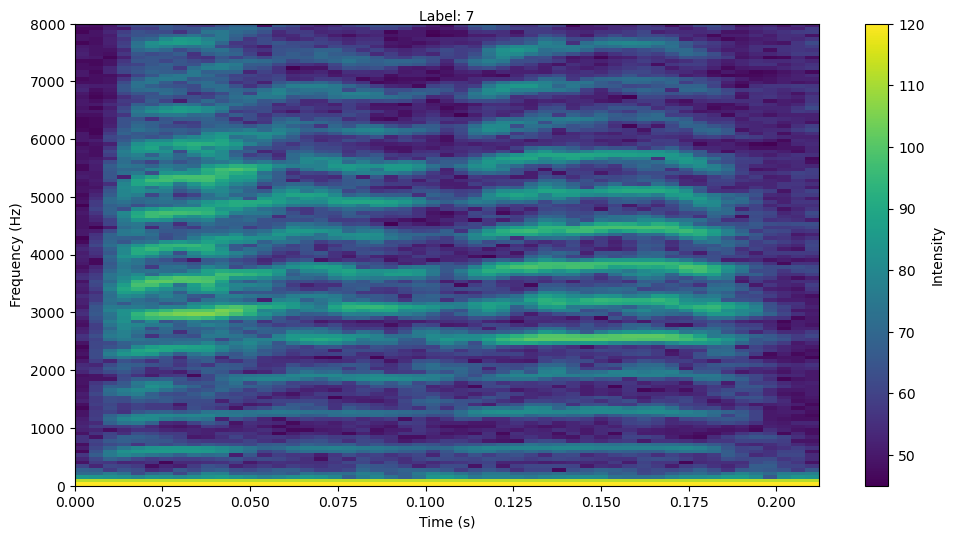

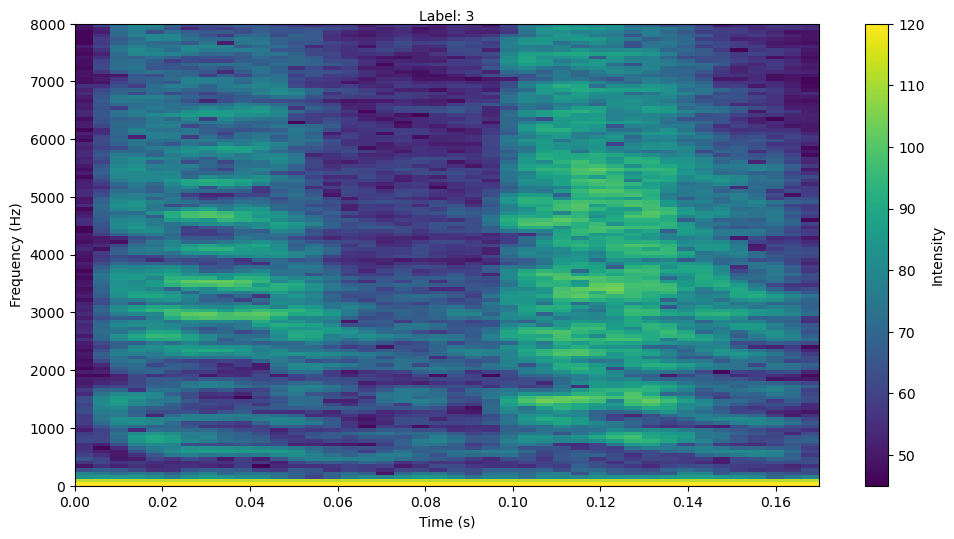

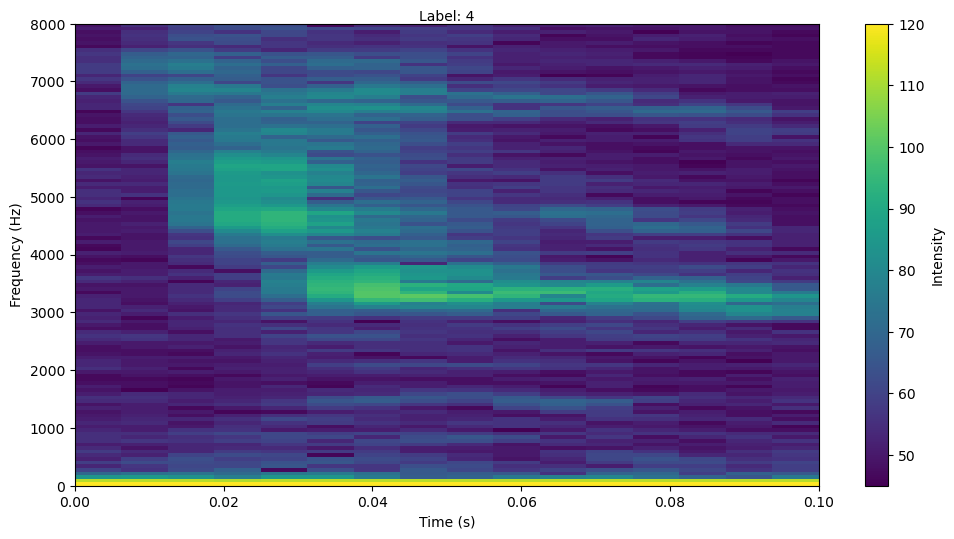

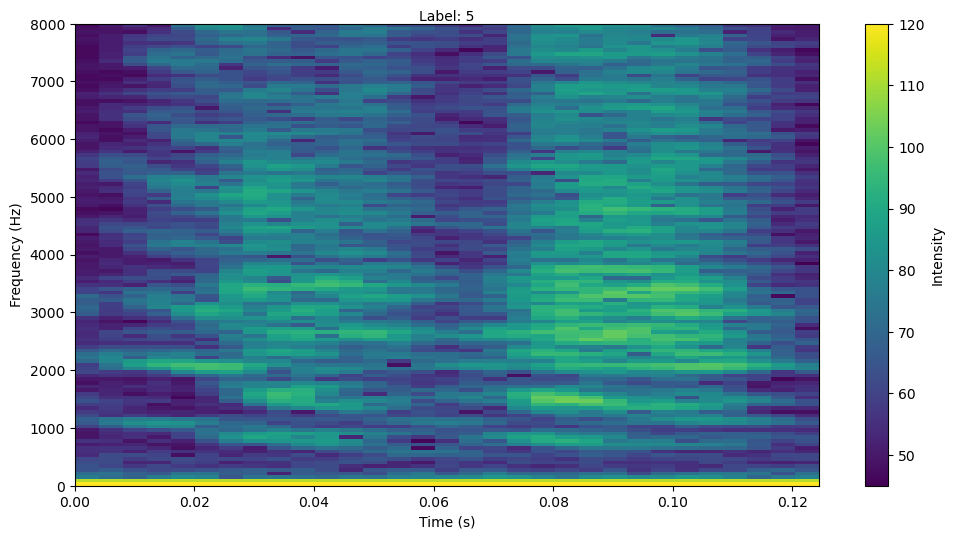

In [13]:
for i, (_, row) in enumerate(filtered_df_2.iterrows()):
    if i >= 10:
        break
    
    onset = row['onset_sec']
    duration = row['duration_sec']
    label = row['cluster_id']
    
    start_index = int(onset * 250)
    end_index = int((onset + duration) * 250)
    
    sample_data = padded_spec_2[:, start_index:end_index]
    
    plt.figure(figsize=(12, 6))
    plt.imshow(sample_data, aspect='auto', origin='lower', 
               extent=[0, max(duration, 0.1), frequencies[0], frequencies[-1]])
    plt.colorbar(label='Intensity')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.text(max(duration, 0.1)/2, frequencies[-1], f'Label: {label}', 
             horizontalalignment='center', verticalalignment='bottom')
    # plt.savefig(f'/home/askr/Projects/neuro2voc/task-5/spectrogram_sample_filtered_{i+1}.png')
    plt.show()
    
    # print(f"Spectrogram sample {i+1} plot saved as 'spectrogram_sample_filtered_{i+1}.png'")
    # print(f"Label: {label}, Duration: {duration:.3f} seconds")

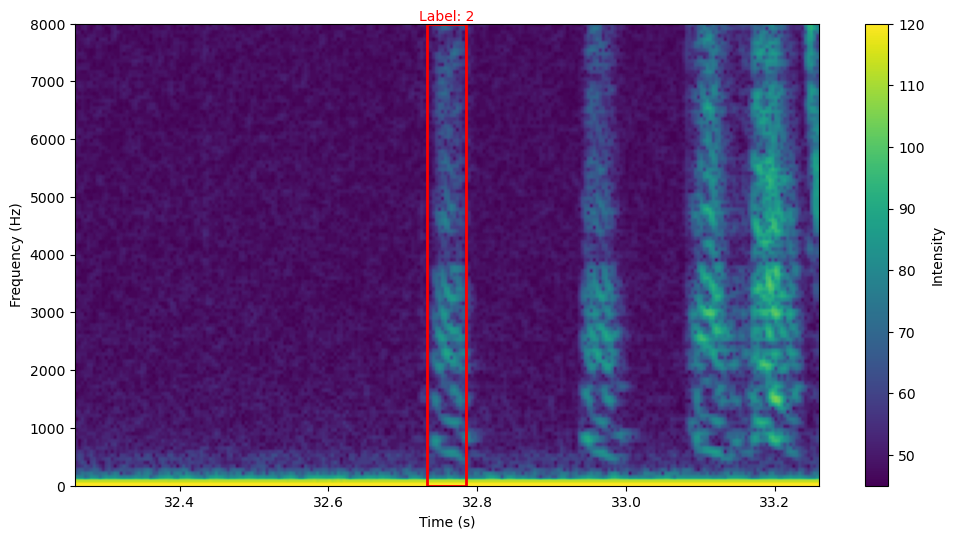

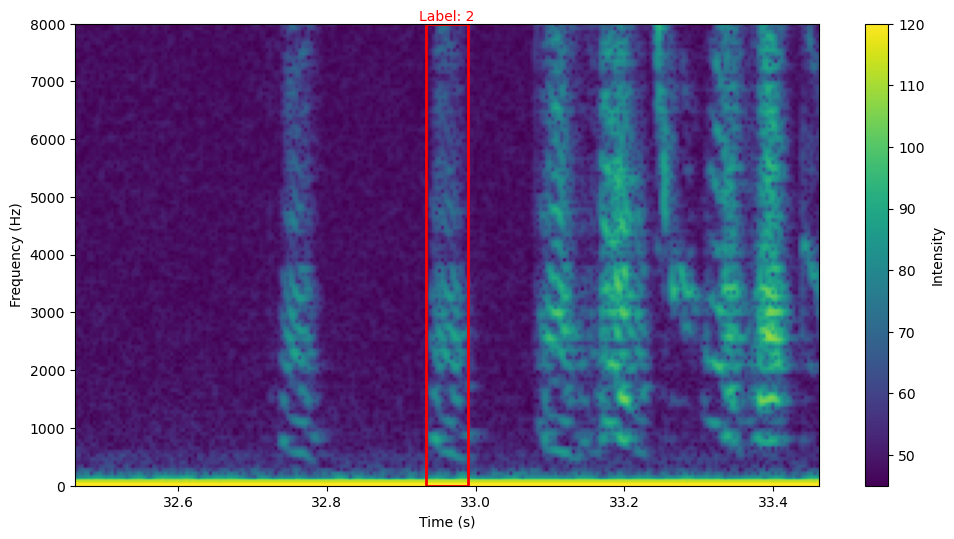

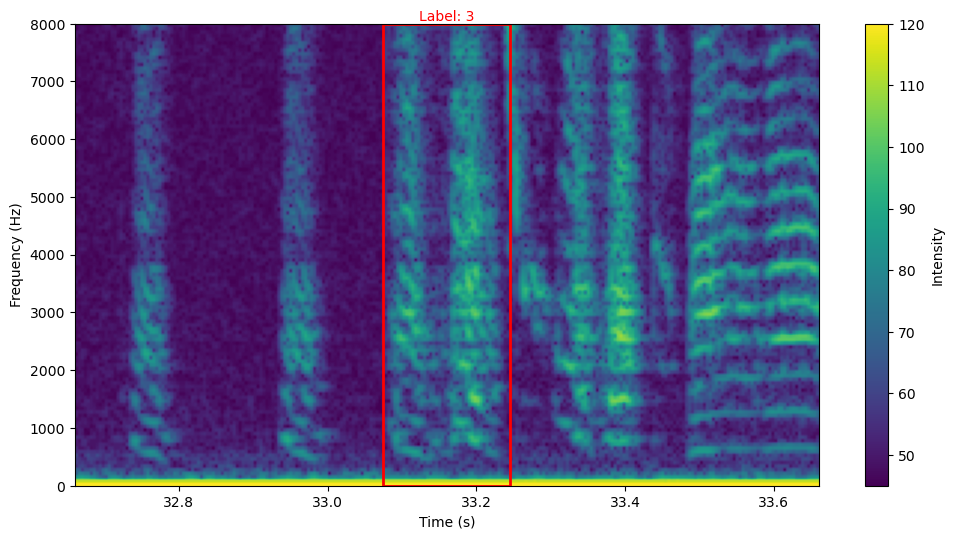

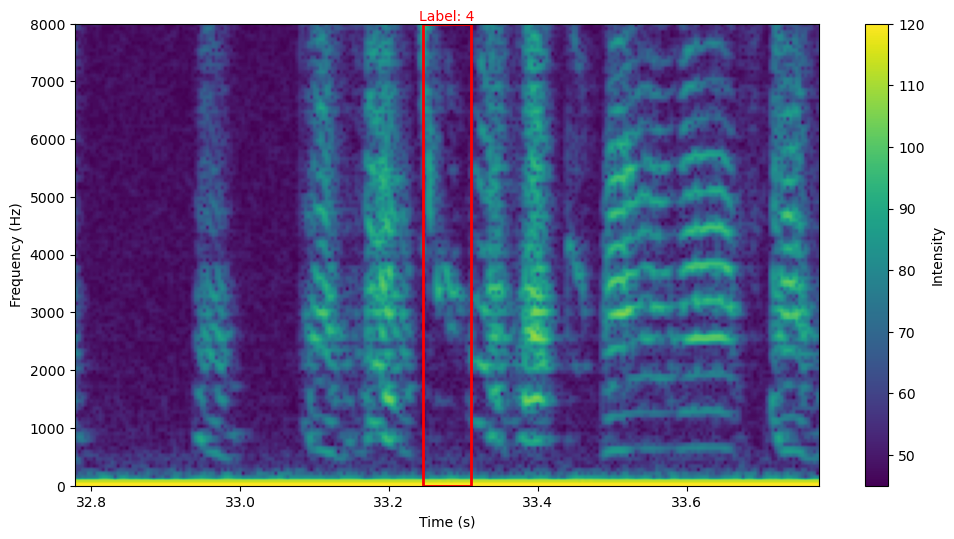

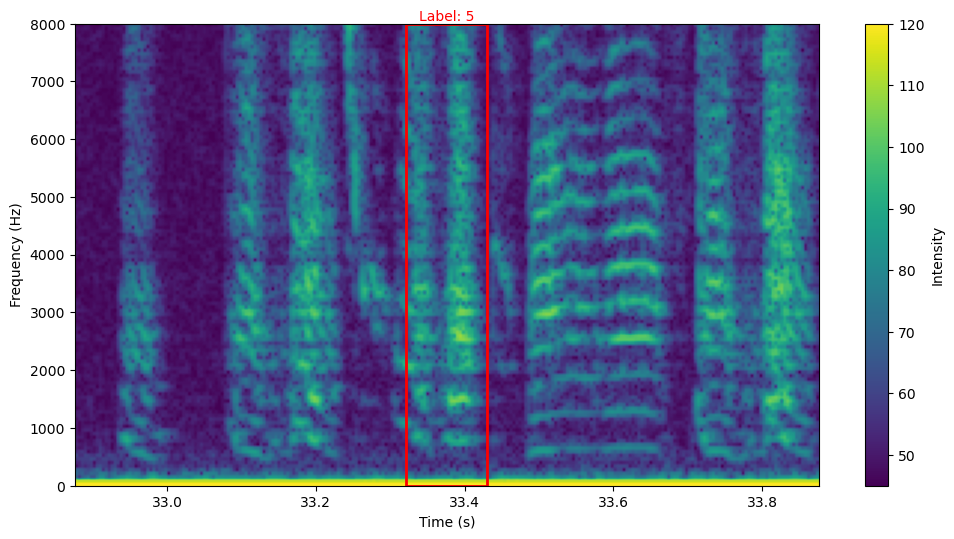

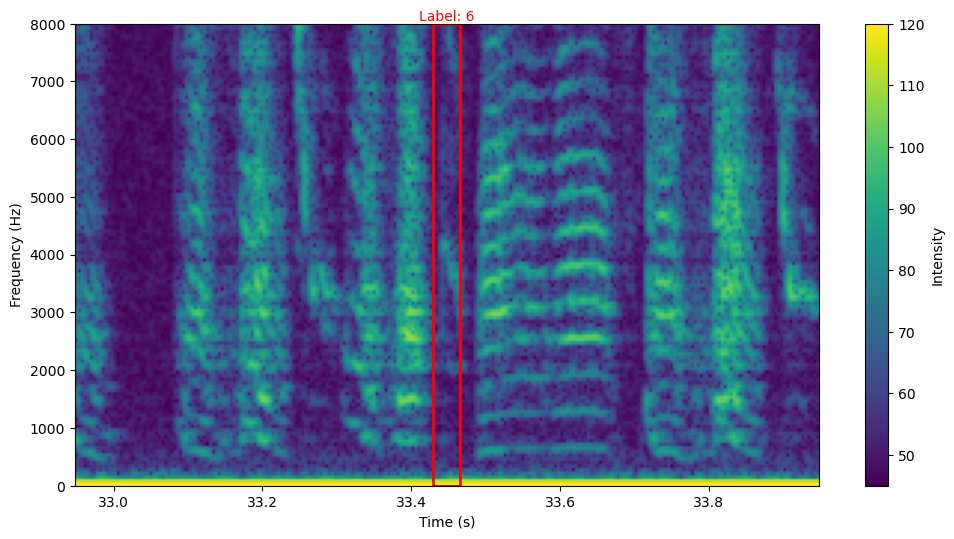

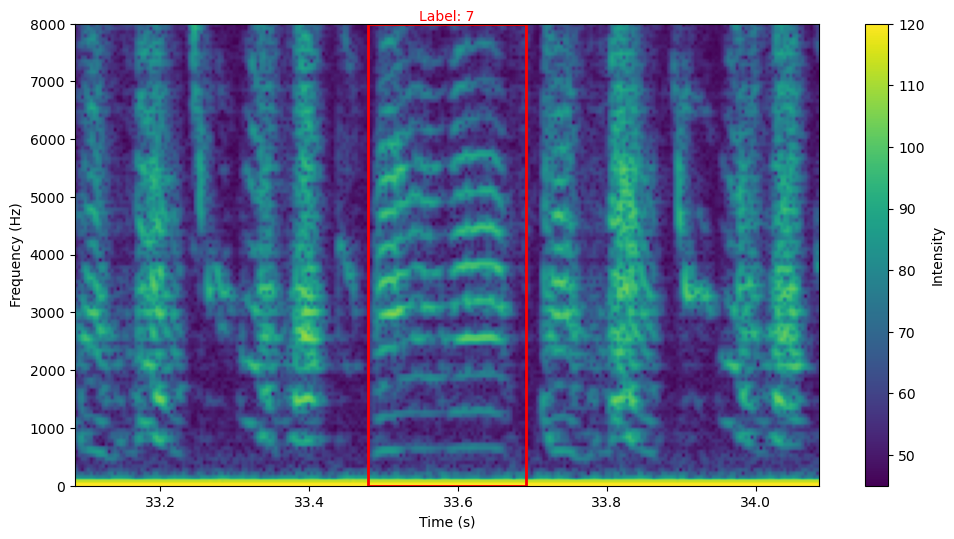

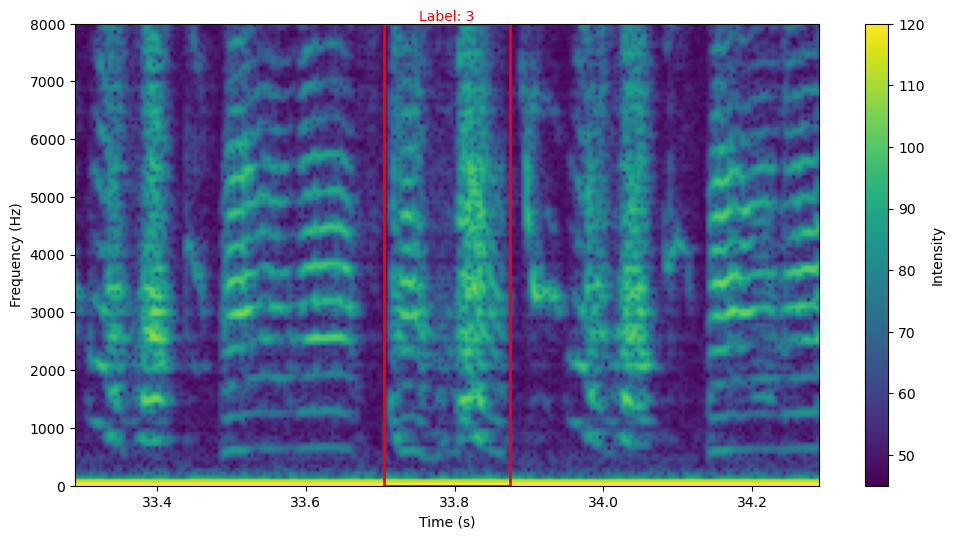

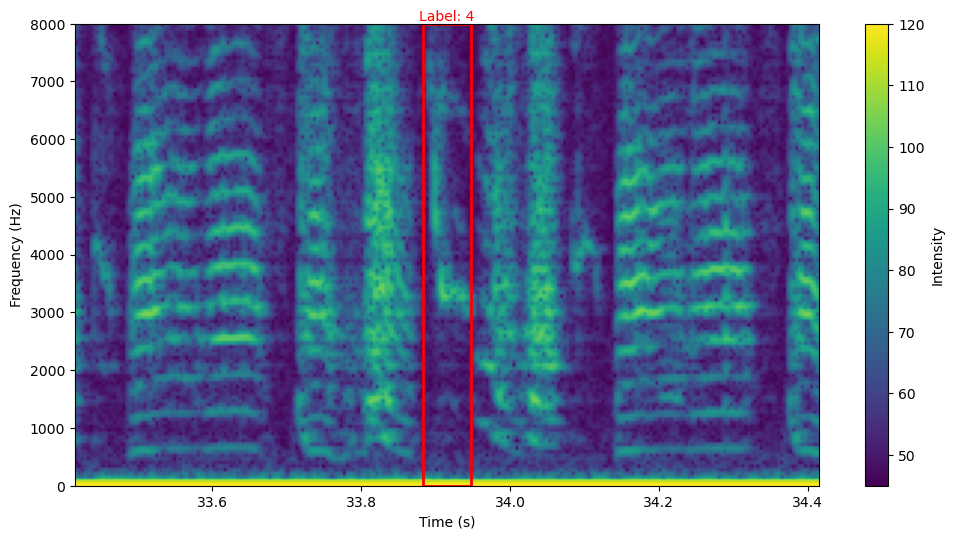

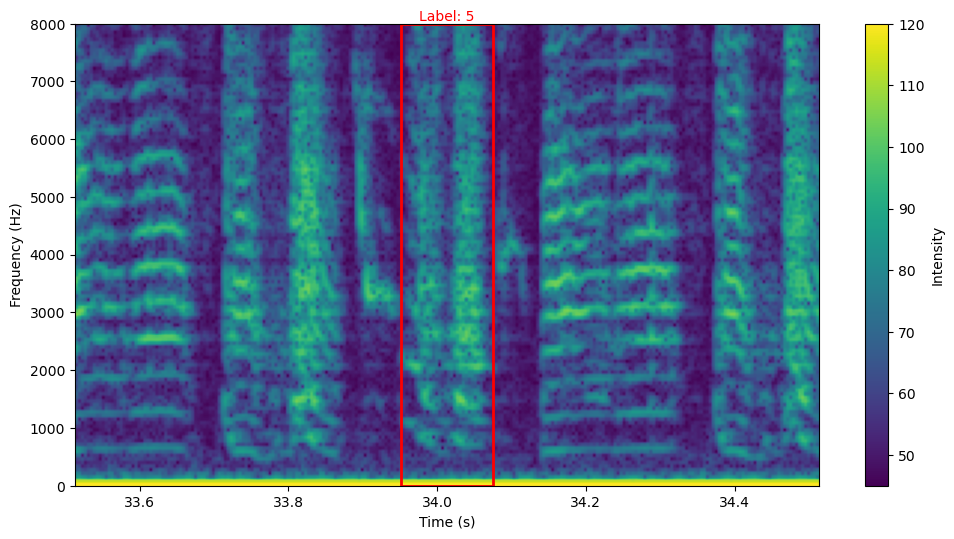

In [14]:
resolution = 0.2  # s
total_duration = padded_spec_2.shape[1] / 250

for i, (_, row) in enumerate(filtered_df_2.iterrows()):
    if i >= 10:
        break
    
    onset = row['onset_sec']
    duration = row['duration_sec']
    label = row['cluster_id']
    
    # calculate the center time
    center_time = onset + duration / 2
    
    # calculate the display start and end, ensure the marked part is centered
    display_start = max(0, center_time - 0.5)  # the total length is 1 second
    display_end = min(total_duration, display_start + 1)
    
    # if it's the end, adjust the start to the previous 1 second
    if display_end == total_duration:
        display_start = max(0, display_end - 1)
    
    start_index = int(display_start * 250)
    end_index = int(display_end * 250)
    
    sample_data = padded_spec_2[:, start_index:end_index]
    
    plt.figure(figsize=(12, 6))
    plt.imshow(sample_data, aspect='auto', origin='lower', 
               extent=[display_start, display_end, frequencies[0], frequencies[-1]])
    plt.colorbar(label='Intensity')
    
    # mark the specific data part
    rect = plt.Rectangle((onset, frequencies[0]), duration, frequencies[-1] - frequencies[0],
                         fill=False, edgecolor='red', linewidth=2)
    plt.gca().add_patch(rect)
    
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.text(onset + duration/2, frequencies[-1], f'Label: {label}', 
             horizontalalignment='center', verticalalignment='bottom', color='red')
    
    # add vertical lines to show the 0.2 second resolution
    # for t in np.arange(display_start, display_end, resolution):
    #     plt.axvline(x=t, color='white', linestyle='--', alpha=0.5)
    plt.show()
    
    # print(f"Spectrogram sample {i+1} plot saved as 'spectrogram_sample_centered_{i+1}.png'")
    # print(f"Label: {label}, Duration: {duration:.3f} seconds, Onset: {onset:.3f} seconds")

# print(f"Total samples with cluster_id 2-8: {len(filtered_df)}")

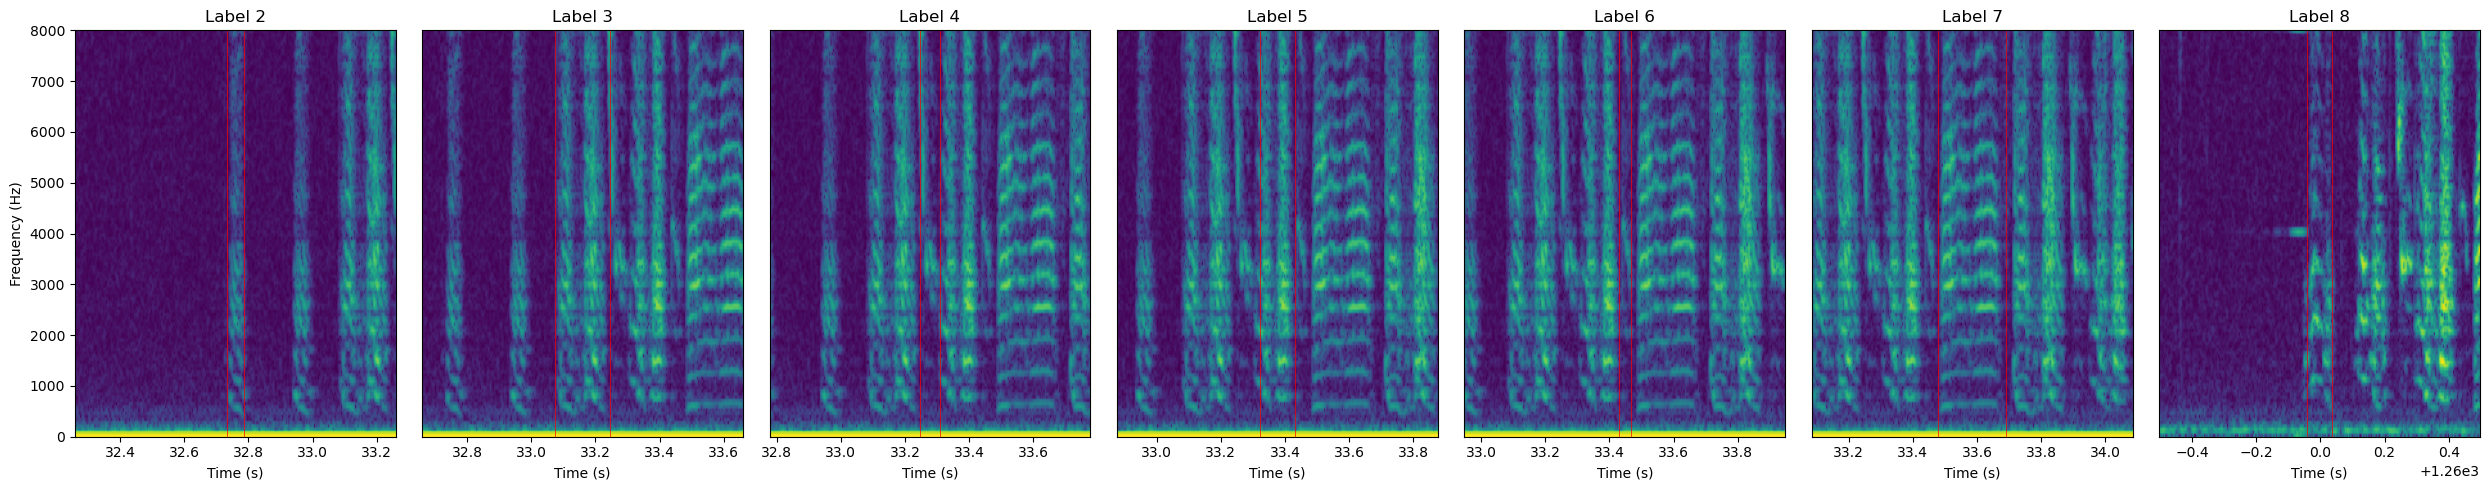

In [25]:
# Create a figure with subplots for labels 2-8 horizontally
fig, axs = plt.subplots(1, 7, figsize=(25, 5))

# Plot one example for each label 2-8
for label_idx, label in enumerate(range(2, 9)):
    # Get first row for this label
    row = filtered_df_2[filtered_df_2['cluster_id'] == label].iloc[0]
    
    onset = row['onset_sec']
    duration = row['duration_sec']
    
    # Calculate center and display window
    center_time = onset + duration / 2
    display_start = max(0, center_time - 0.5)
    display_end = min(total_duration, display_start + 1)
    
    if display_end == total_duration:
        display_start = max(0, display_end - 1)
    
    # Get spectrogram slice
    start_index = int(display_start * 250)
    end_index = int(display_end * 250)
    sample_data = padded_spec_2[:, start_index:end_index]
    
    # Plot spectrogram
    im = axs[label_idx].imshow(sample_data, aspect='auto', origin='lower',
                              extent=[display_start, display_end, frequencies[0], frequencies[-1]])
    
    # Add rectangle marking the vocalization with thinner linewidth
    rect = plt.Rectangle((onset, frequencies[0]), duration, frequencies[-1] - frequencies[0],
                        fill=False, edgecolor='red', linewidth=0.5)
    axs[label_idx].add_patch(rect)
    
    # Labels and title
    if label_idx == 0:  # Only show y-label for leftmost plot
        axs[label_idx].set_ylabel('Frequency (Hz)')
    else:
        axs[label_idx].set_yticks([])
    
    axs[label_idx].set_xlabel('Time (s)')
    axs[label_idx].set_title(f'Label {label}')
    
plt.tight_layout()
plt.show()

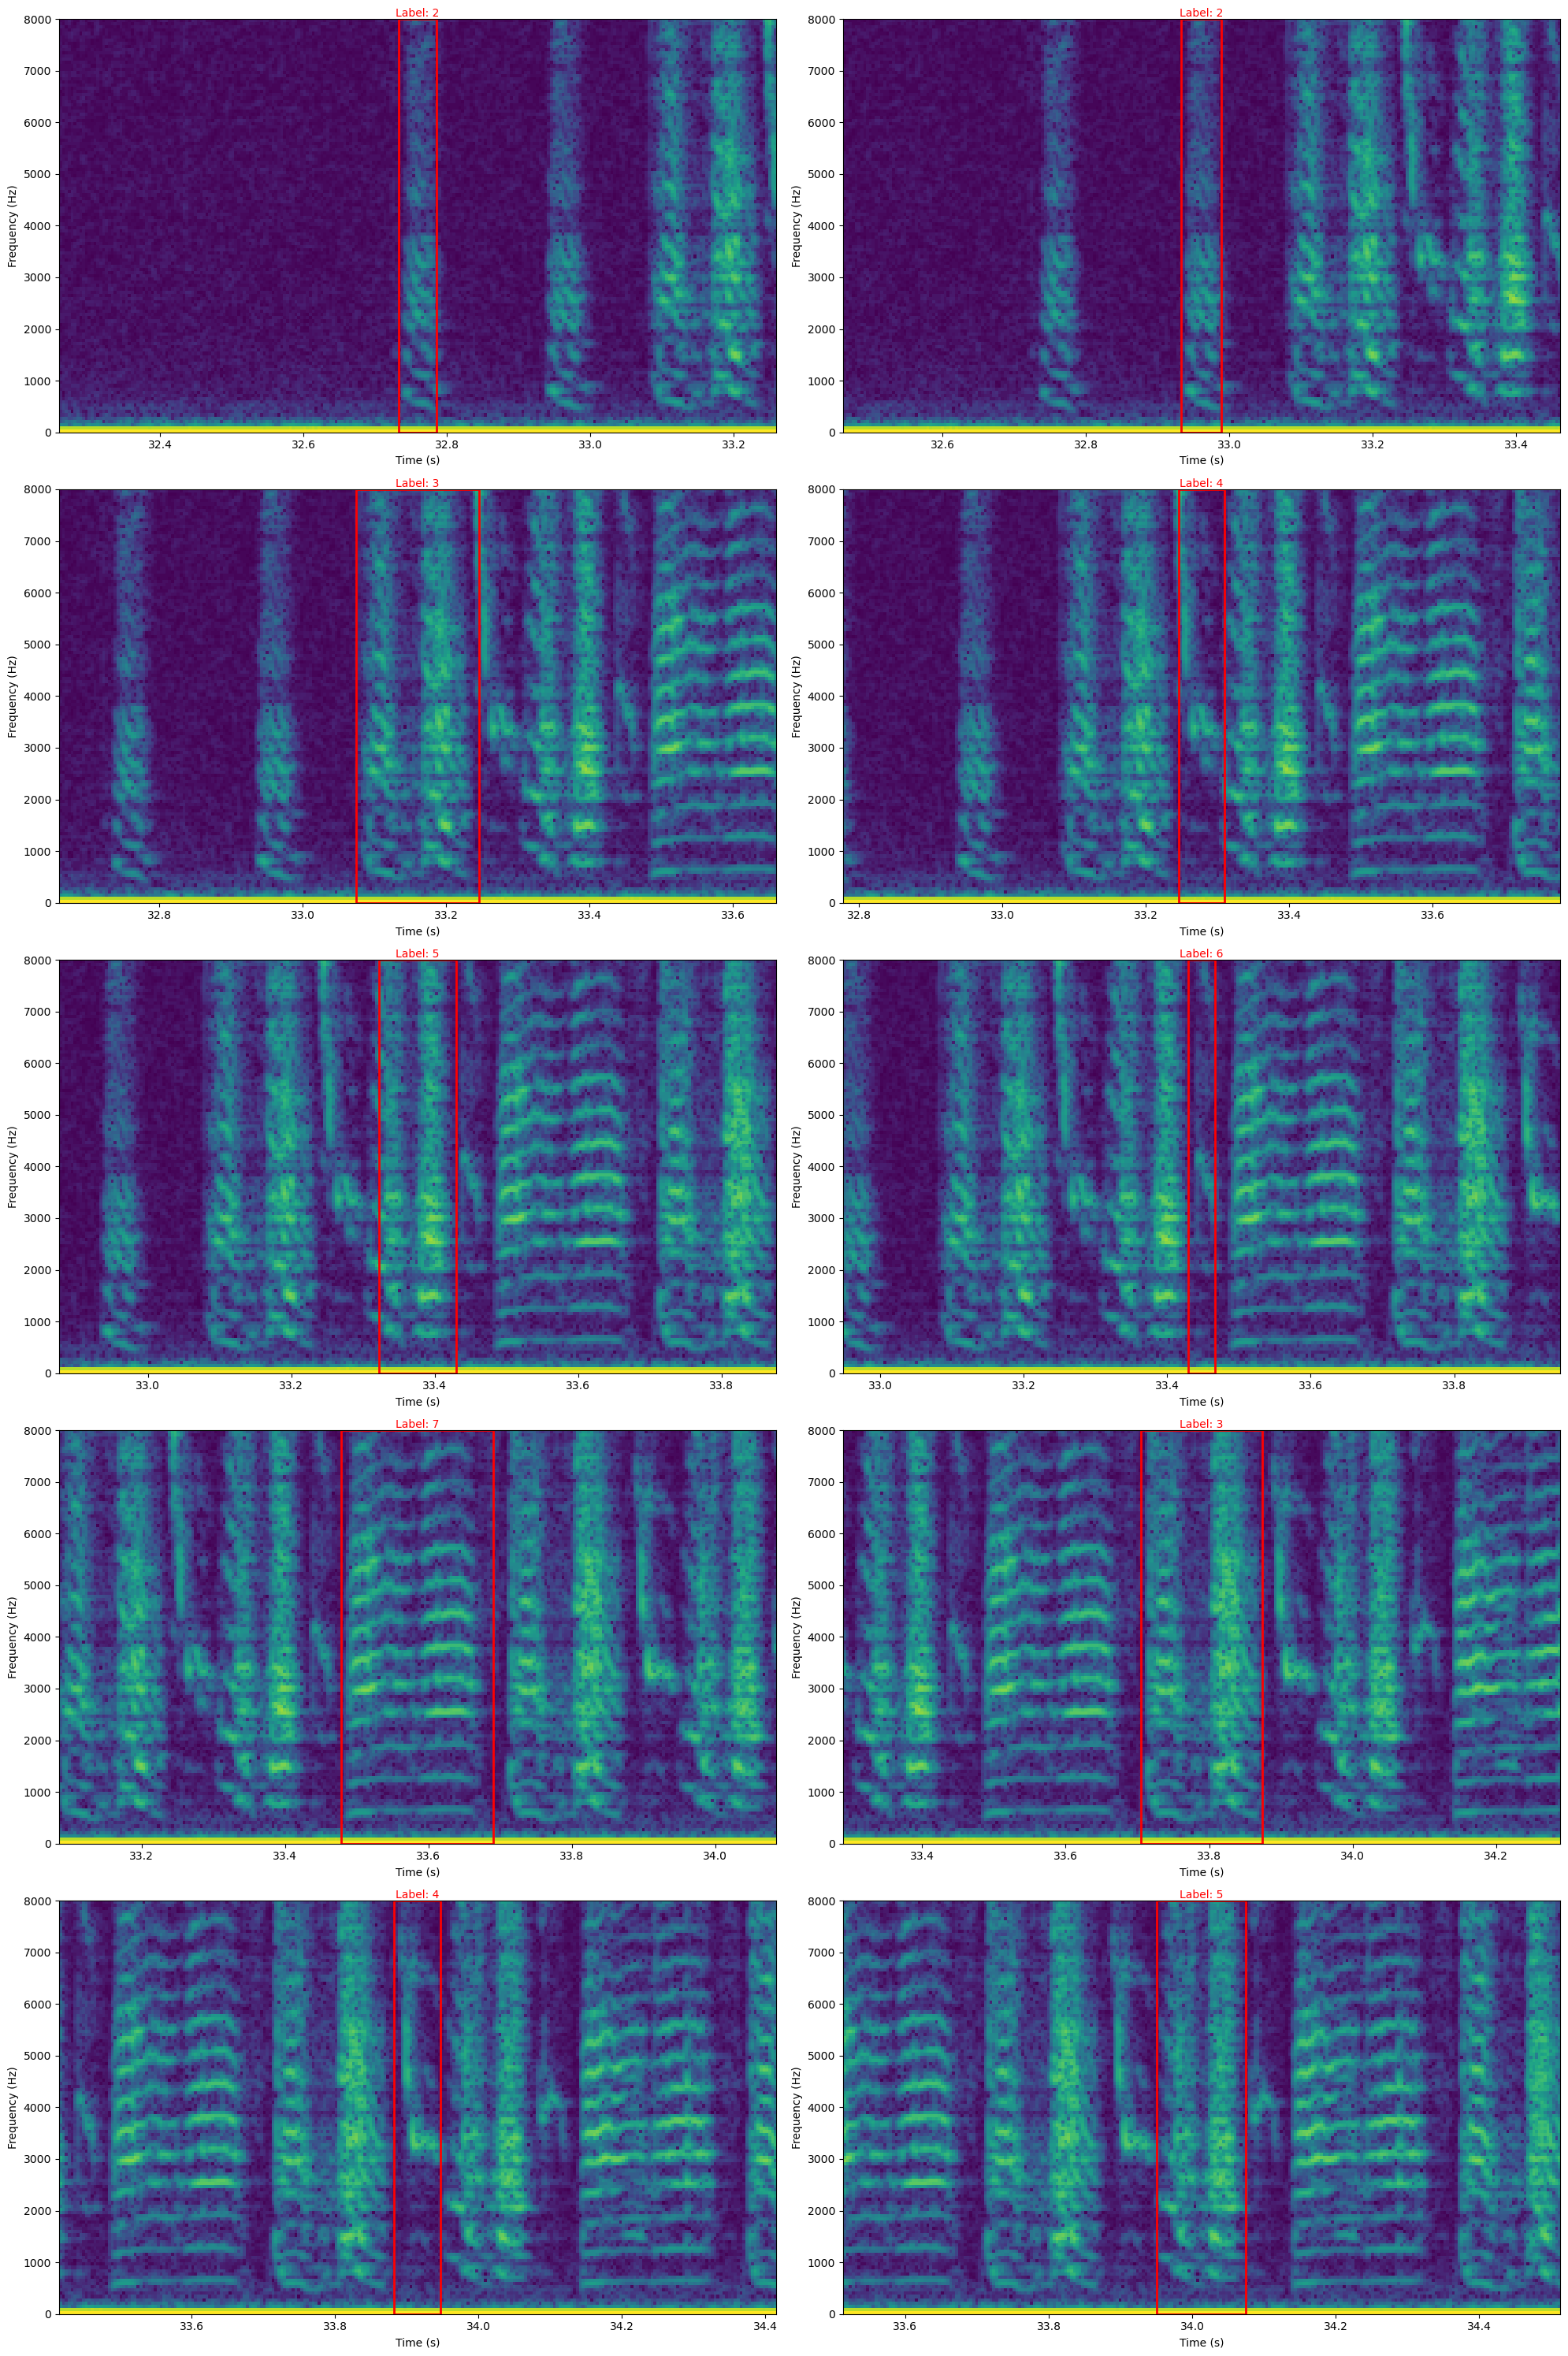

Combined spectrogram samples plot saved as 'spectrogram_samples_combined.png'


In [31]:
fig, axs = plt.subplots(5, 2, figsize=(20, 30))
axs = axs.flatten()

for i, (_, row) in enumerate(filtered_df_2.iterrows()):
    if i >= 10:
        break
    
    onset = row['onset_sec']
    duration = row['duration_sec']
    label = row['cluster_id']
    
    center_time = onset + duration / 2
    display_start = max(0, center_time - 0.5)
    display_end = min(total_duration, display_start + 1)
    
    if display_end == total_duration:
        display_start = max(0, display_end - 1)
    
    start_index = int(display_start * 250)
    end_index = int(display_end * 250)
    
    sample_data = padded_spec_2[:, start_index:end_index]
    
    im = axs[i].imshow(sample_data, aspect='auto', origin='lower', 
                       extent=[display_start, display_end, frequencies[0], frequencies[-1]])
    
    rect = plt.Rectangle((onset, frequencies[0]), duration, frequencies[-1] - frequencies[0],
                         fill=False, edgecolor='red', linewidth=2)
    axs[i].add_patch(rect)
    
    axs[i].set_xlabel('Time (s)')
    axs[i].set_ylabel('Frequency (Hz)')
    axs[i].text(onset + duration/2, frequencies[-1], f'Label: {label}', 
                horizontalalignment='center', verticalalignment='bottom', color='red')

# fig.colorbar(im, ax=axs.ravel().tolist(), label='Intensity')

plt.tight_layout()
plt.show()

print(f"Combined spectrogram samples plot saved as 'spectrogram_samples_combined.png'")

# Save

In [47]:
import os

spec_count = sum(len(df) for df in [filtered_df_0, filtered_df_1, filtered_df_2])
print(f"Total number of spectrograms to be saved: {spec_count}")


Total number of spectrograms to be saved: 3459


In [48]:
total_saved = 0

for df_num, (filtered_df, padded_spec) in enumerate([(filtered_df_0, padded_spec_0), 
                                                     (filtered_df_1, padded_spec_1), 
                                                     (filtered_df_2, padded_spec_2)], 1):
    for _, row in filtered_df.iterrows():
        onset = row['onset_sec']
        duration = row['duration_sec']
        label = row['cluster_id']
        
        start_index = int(onset * 250)
        end_index = int((onset + duration) * 250)
        
        sample_data = padded_spec[:, start_index:end_index]
        
        # Create filename with leading zeros
        filename = f"spec_{total_saved:04d}_label_{label}_df{df_num}.npy"
        filepath = os.path.join(spec_dir, filename)
        
        # Save the spectrogram data
        np.save(filepath, sample_data)
        
        total_saved += 1
        
        if total_saved % 100 == 0:  # Print progress every 100 samples
            print(f"Saved {total_saved} spectrograms")

print(f"Total spectrograms saved: {total_saved}")

Saved 100 spectrograms
Saved 200 spectrograms
Saved 300 spectrograms
Saved 400 spectrograms
Saved 500 spectrograms
Saved 600 spectrograms
Saved 700 spectrograms
Saved 800 spectrograms
Saved 900 spectrograms
Saved 1000 spectrograms
Saved 1100 spectrograms
Saved 1200 spectrograms
Saved 1300 spectrograms
Saved 1400 spectrograms
Saved 1500 spectrograms
Saved 1600 spectrograms
Saved 1700 spectrograms
Saved 1800 spectrograms
Saved 1900 spectrograms
Saved 2000 spectrograms
Saved 2100 spectrograms
Saved 2200 spectrograms
Saved 2300 spectrograms
Saved 2400 spectrograms
Saved 2500 spectrograms
Saved 2600 spectrograms
Saved 2700 spectrograms
Saved 2800 spectrograms
Saved 2900 spectrograms
Saved 3000 spectrograms
Saved 3100 spectrograms
Saved 3200 spectrograms
Saved 3300 spectrograms
Saved 3400 spectrograms
Total spectrograms saved: 3459


# Read in saved, convert to MFCC

In [89]:
def hz_to_mel(hz):
    return 2595 * np.log10(1 + hz / 700)

def mel_to_hz(mel):
    return 700 * (10**(mel / 2595) - 1)

def create_mel_filterbank(frequencies, n_mels):
    low_freq_mel = hz_to_mel(frequencies[0])
    high_freq_mel = hz_to_mel(frequencies[-1])
    mel_points = np.linspace(low_freq_mel, high_freq_mel, n_mels + 2)
    hz_points = mel_to_hz(mel_points)
    
    fbank = np.zeros((n_mels, len(frequencies)))
    for i in range(1, n_mels + 1):
        left = np.searchsorted(frequencies, hz_points[i-1], side='left')
        center = np.searchsorted(frequencies, hz_points[i])
        right = np.searchsorted(frequencies, hz_points[i+1], side='right')
        
        for j in range(left, right):
            if j < center:
                fbank[i-1, j] = (frequencies[j] - hz_points[i-1]) / (hz_points[i] - hz_points[i-1])
            else:
                fbank[i-1, j] = (hz_points[i+1] - frequencies[j]) / (hz_points[i+1] - hz_points[i])
    
    return fbank

def spectrogram_to_mfcc(spectrogram, frequencies, n_mfcc=13, n_mels=40):
    # Convert power spectrogram to dB scale
    log_spec = 10.0 * np.log10(spectrogram + 1e-10)
    
    # Create mel filterbank
    mel_filter = create_mel_filterbank(frequencies, n_mels)
    
    # Apply mel filterbank
    mel_spec = np.dot(mel_filter, log_spec)
    
    # Compute MFCC
    mfcc = dct(mel_spec, type=2, axis=0, norm='ortho')[:n_mfcc]
    return mfcc

In [90]:
for filename in os.listdir(spec_dir):
    if filename.endswith('.npy'):
        spec_path = os.path.join(spec_dir, filename)
        spectrogram = np.load(spec_path)
        
        mfcc = spectrogram_to_mfcc(spectrogram, frequencies)
        
        mfcc_filename = f"mfcc_{filename}"
        mfcc_path = os.path.join(mfcc_dir, mfcc_filename)
        
        np.save(mfcc_path, mfcc)

print(f"MFCC conversion completed. Files saved in {mfcc_dir}")

MFCC conversion completed. Files saved in M:\neuro2voc\task-5\dtw\MFCC


In [91]:
import random

def get_files_for_label(label):
    return [f for f in os.listdir(mfcc_dir) if f.startswith(f'mfcc_spec_') and f'label_{label}_' in f and f.endswith('.npy')]

for label in range(2, 8):
    print(f"\nLabel {label}:")
    label_files = get_files_for_label(label)
    
    selected_files = random.sample(label_files, min(5, len(label_files)))
    
    for file in selected_files:
        file_path = os.path.join(mfcc_dir, file)
        mfcc_data = np.load(file_path)
        print(f"File: {file}")
        print(f"MFCC shape: {mfcc_data.shape}")



Label 2:
File: mfcc_spec_0773_label_2_df3.npy
MFCC shape: (13, 14)
File: mfcc_spec_0424_label_2_df2.npy
MFCC shape: (13, 14)
File: mfcc_spec_0958_label_2_df3.npy
MFCC shape: (13, 13)
File: mfcc_spec_2639_label_2_df3.npy
MFCC shape: (13, 13)
File: mfcc_spec_0915_label_2_df3.npy
MFCC shape: (13, 17)

Label 3:
File: mfcc_spec_1144_label_3_df3.npy
MFCC shape: (13, 40)
File: mfcc_spec_0156_label_3_df1.npy
MFCC shape: (13, 39)
File: mfcc_spec_0289_label_3_df1.npy
MFCC shape: (13, 40)
File: mfcc_spec_3073_label_3_df3.npy
MFCC shape: (13, 40)
File: mfcc_spec_2425_label_3_df3.npy
MFCC shape: (13, 43)

Label 4:
File: mfcc_spec_2919_label_4_df3.npy
MFCC shape: (13, 19)
File: mfcc_spec_1989_label_4_df3.npy
MFCC shape: (13, 18)
File: mfcc_spec_0781_label_4_df3.npy
MFCC shape: (13, 19)
File: mfcc_spec_3094_label_4_df3.npy
MFCC shape: (13, 19)
File: mfcc_spec_1685_label_4_df3.npy
MFCC shape: (13, 17)

Label 5:
File: mfcc_spec_2212_label_5_df3.npy
MFCC shape: (13, 32)
File: mfcc_spec_2997_label_5_df3

# Wav2Vec (unfinished)

In [82]:
from transformers import Wav2Vec2Model, Wav2Vec2FeatureExtractor
import torchaudio
import torch

In [77]:
model_name = "facebook/wav2vec2-base"
model = Wav2Vec2Model.from_pretrained(model_name)
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)

config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

c:\Users\askrb\miniforge3\envs\neuro2voc_env\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\askrb\.cache\huggingface\hub\models--facebook--wav2vec2-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
c:\Users\askrb\miniforge3\envs\neuro2voc_env\Lib\site-packages\transformers\configuration_utils.p

pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

In [83]:
def get_embeddings_from_spectrogram(spectrogram, frequencies):
    # normalize
    normalized_spec = (spectrogram - np.mean(spectrogram)) / np.std(spectrogram)
    # reshape
    input_values = normalized_spec.reshape(1, -1)
    input_tensor = torch.tensor(input_values, dtype=torch.float32)
    
    with torch.no_grad():
        outputs = model(input_tensor)
        embeddings = outputs.last_hidden_state
    
    return embeddings.squeeze().numpy()

In [84]:
for filename in os.listdir(spec_dir):
    if filename.endswith('.npy'):
        spec_path = os.path.join(spec_dir, filename)
        spectrogram = np.load(spec_path)
        
        embeddings = get_embeddings_from_spectrogram(spectrogram, frequencies)
        
        # Save embeddings
        output_path = os.path.join(embeddings_dir, f"{os.path.splitext(filename)[0]}_embedding.npy")
        np.save(output_path, embeddings)
        
        print(f"Processed {filename}, embedding shape: {embeddings.shape}")

Processed spec_0000_label_2_df1.npy, embedding shape: (4, 768)
Processed spec_0001_label_2_df1.npy, embedding shape: (4, 768)
Processed spec_0002_label_2_df1.npy, embedding shape: (4, 768)
Processed spec_0003_label_2_df1.npy, embedding shape: (4, 768)
Processed spec_0004_label_3_df1.npy, embedding shape: (14, 768)
Processed spec_0005_label_4_df1.npy, embedding shape: (6, 768)
Processed spec_0006_label_5_df1.npy, embedding shape: (11, 768)
Processed spec_0007_label_6_df1.npy, embedding shape: (3, 768)
Processed spec_0008_label_7_df1.npy, embedding shape: (19, 768)
Processed spec_0009_label_3_df1.npy, embedding shape: (14, 768)
Processed spec_0010_label_4_df1.npy, embedding shape: (6, 768)
Processed spec_0011_label_5_df1.npy, embedding shape: (13, 768)
Processed spec_0012_label_2_df1.npy, embedding shape: (5, 768)
Processed spec_0013_label_3_df1.npy, embedding shape: (16, 768)
Processed spec_0014_label_4_df1.npy, embedding shape: (6, 768)
Processed spec_0015_label_5_df1.npy, embedding sh

RuntimeError: Calculated padded input size per channel: (1). Kernel size: (2). Kernel size can't be greater than actual input size

# DTW

In [12]:
from dtaidistance import dtw_ndim
from collections import defaultdict
from scipy.interpolate import interp1d

In [23]:
def warp_mfcc(mfcc, reference_mfcc):
    # shape: (13 MFCC, time bins)
    path = dtw_ndim.warping_path(mfcc.T, reference_mfcc.T)
    warped_mfcc = np.zeros((mfcc.shape[0], reference_mfcc.shape[1]))
    
    # Initialize with the first mapping
    last_i, last_j = path[0]
    warped_mfcc[:, last_j] = mfcc[:, last_i]
    
    # Process the rest of the path
    for i, j in path[1:]:
        if j != last_j:
            # We've moved to a new column in the reference
            warped_mfcc[:, j] = mfcc[:, i]
        # else: we're still on the same reference column, so we don't update
        last_i, last_j = i, j
    
    return warped_mfcc

In [24]:
label_groups = defaultdict(list)

for filename in os.listdir(mfcc_dir):
    if filename.startswith('mfcc_spec_') and filename.endswith('.npy'):
        parts = filename.split('_')
        label = int(parts[parts.index('label') + 1])
        label_groups[label].append(os.path.join(mfcc_dir, filename))

In [49]:
for label, file_list in label_groups.items():
    mfccs = [np.load(f) for f in file_list]
    
    # Find the MFCC with the longest length to use as reference
    longest_length_idx = np.argmax([mfcc.shape[1] for mfcc in mfccs])
    reference_mfcc = mfccs[longest_length_idx]
    print(reference_mfcc.shape[0])
    print(reference_mfcc.shape[1])
    
    for i, (mfcc, file_path) in enumerate(zip(mfccs, file_list)):
        warped_mfcc = warp_mfcc(mfcc, reference_mfcc)
        
        # Save warped MFCC
        output_filename = os.path.basename(file_path).replace('mfcc_', 'warped_mfcc_')
        output_path = os.path.join(dtw_mfcc_dir, output_filename)
        np.save(output_path, warped_mfcc)
    
    print(f"Warped and saved MFCCs for label {label}")


13
26
13
44
13
20
13
43
13
15
13
56
13
30


In [50]:
# Read directly from the output_path and select label 2
label_2_files = [f for f in os.listdir(dtw_mfcc_dir) if f.startswith('warped_mfcc_') and f.endswith('.npy') and '_label_2_' in f]

# Load and concatenate the data for label 2
label_2_data = []
for file in label_2_files:
    file_path = os.path.join(dtw_mfcc_dir, file)
    mfcc = np.load(file_path)
    label_2_data.append(mfcc)

# Concatenate the data along the time axis (assuming this is axis 1)
concatenated_data = np.concatenate(label_2_data, axis=1)

# Print the shape of the concatenated data
print(f"Shape of concatenated data for label 2: {concatenated_data.shape}")


Shape of concatenated data for label 2: (13, 12272)


# PCA

In [60]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [61]:
pca_dir = r"M:\neuro2voc\task-5\dtw\PCA-MFCC"

label_groups = {}

for filename in os.listdir(dtw_mfcc_dir):
    if filename.startswith('warped_mfcc_') and filename.endswith('.npy'):
        parts = filename.split('_')
        label = int(parts[parts.index('label') + 1])
        if label not in label_groups:
            label_groups[label] = []
        label_groups[label].append(os.path.join(dtw_mfcc_dir, filename))

In [62]:
# PCA for each label
for label, file_list in label_groups.items():
    mfccs = [np.load(f) for f in file_list]
    
    # Stack MFCCs (each row is now a full MFCC sequence)
    stacked_mfccs = np.vstack(mfccs)
    
    # Perform PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(stacked_mfccs)
    
    # Save PC1 and PC2
    np.save(os.path.join(pca_dir, f'pca_components_label_{label}.npy'), pca.components_)
    
    print(f"Completed PCA for label {label}")
    print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
    print(f"Shape of PCA components: {pca.components_.shape}")

print(f"PCA analysis completed. Results saved in {pca_dir}")

Completed PCA for label 2
Explained variance ratio: [9.99886382e-01 6.75672894e-05]
Shape of PCA components: (2, 26)
Completed PCA for label 3
Explained variance ratio: [9.99784102e-01 7.43525836e-05]
Shape of PCA components: (2, 44)
Completed PCA for label 4
Explained variance ratio: [9.99327556e-01 3.68900983e-04]
Shape of PCA components: (2, 20)
Completed PCA for label 5
Explained variance ratio: [9.99851949e-01 3.64295440e-05]
Shape of PCA components: (2, 43)
Completed PCA for label 6
Explained variance ratio: [9.99795898e-01 9.91786331e-05]
Shape of PCA components: (2, 15)
Completed PCA for label 7
Explained variance ratio: [9.99868897e-01 4.64911185e-05]
Shape of PCA components: (2, 56)
Completed PCA for label 8
Explained variance ratio: [9.99831707e-01 5.95850065e-05]
Shape of PCA components: (2, 30)
PCA analysis completed. Results saved in M:\neuro2voc\task-5\dtw\PCA-MFCC


: 

In [57]:
# Plot PCA results for each label
for label in label_groups.keys():
    # Load PCA results
    pca_result = np.load(os.path.join(pca_dir, f'pca_result_label_{label}.npy'))
    explained_variance_ratio = np.load(os.path.join(pca_dir, f'pca_explained_variance_ratio_label_{label}.npy'))
    
    # Create a new figure for each label
    plt.figure(figsize=(12, 6))
    
    # Plot the cumulative explained variance ratio
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
    plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'bo-')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title(f'PCA Analysis for Label {label}')
    plt.grid(True)
    
    # Add a horizontal line at 95% explained variance
    plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
    
    # Find the number of components needed to explain 95% of the variance
    n_components_95 = next(i for i, ratio in enumerate(cumulative_variance_ratio) if ratio >= 0.95) + 1
    plt.annotate(f'95% at {n_components_95} components', 
                 xy=(n_components_95, 0.95), 
                 xytext=(n_components_95+1, 0.90),
                 arrowprops=dict(facecolor='black', shrink=0.05))
    
    plt.legend()
    
    # Save the plot
    plt.savefig(os.path.join(pca_dir, f'pca_plot_label_{label}.png'))
    plt.close()

print(f"PCA plots have been saved in {pca_dir}")


PCA plots have been saved in M:\neuro2voc\task-5\dtw\PCA-MFCC


In [58]:

# Load and process PC1 and PC2 for label 2
speechPC1_label_2 = np.load(os.path.join(pca_dir, 'pca_components_label_2.npy'))[0]
speechPC2_label_2 = np.load(os.path.join(pca_dir, 'pca_components_label_2.npy'))[1]

# Check dimensionalities
print("speechPC1_label_2 shape:", speechPC1_label_2.shape)
print("speechPC2_label_2 shape:", speechPC2_label_2.shape)

speechPC1_label_2 shape: (26,)
speechPC2_label_2 shape: (26,)


# Read in Cebra

In [34]:
embeddings_dir = r"M:\neuro2voc\task-5\cebra\embeddings"
primary_components_dir = r"M:\neuro2voc\task-5\cebra\primaryComponents"
tsne_dir = r"M:\neuro2voc\task-5\cebra\tSNEresults"

# Read embeddings data
embeddings = np.load(os.path.join(embeddings_dir, "embeddings_cebra.npy"))
labels = np.load(os.path.join(embeddings_dir, "labels_cebra.npy"))

# Check dimensions of embeddings and labels
print("Embeddings shape:", embeddings.shape)
print("Labels shape:", labels.shape)

# Read primary components
pc1 = np.load(os.path.join(primary_components_dir, "pc1.npy"))
pc2 = np.load(os.path.join(primary_components_dir, "pc2.npy"))

# Check dimensions of primary components
print("PC1 shape:", pc1.shape)
print("PC2 shape:", pc2.shape)


Embeddings shape: (53792, 32)
Labels shape: (53792,)
PC1 shape: (53792,)
PC2 shape: (53792,)


In [39]:
label_2_indices = np.where(labels == 2)[0]

pc1_label_2 = pc1[label_2_indices]
pc2_label_2 = pc2[label_2_indices]

print("Label 2 indices shape:", label_2_indices.shape)
print("PC1 for label 2 shape:", pc1_label_2.shape)
print("PC2 for label 2 shape:", pc2_label_2.shape)



Label 2 indices shape: (4721,)
PC1 for label 2 shape: (4721,)
PC2 for label 2 shape: (4721,)


In [40]:
# Get PC1 and PC2 for label 2 group
label_2_indices = np.where(labels == 2)[0]
pc1_label_2 = pc1[label_2_indices]
pc2_label_2 = pc2[label_2_indices]

# Check dimensions
print("PC1 for label 2 shape:", pc1_label_2.shape)
print("PC2 for label 2 shape:", pc2_label_2.shape)

# Plot PC1 vs PC2 for label 2
plt.figure(figsize=(12, 6))
plt.scatter(pc1_label_2, pc2_label_2, alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PC1 vs PC2 for Label 2')
plt.grid(True)

# Save the plot
plt.savefig(os.path.join(primary_components_dir, 'pc1_vs_pc2_label_2.png'))
plt.close()

print(f"PC1 vs PC2 plot for Label 2 has been saved in {primary_components_dir}")


PC1 for label 2 shape: (4721,)
PC2 for label 2 shape: (4721,)
PC1 vs PC2 plot for Label 2 has been saved in M:\neuro2voc\task-5\cebra\primaryComponents


speechPC1_label_2 shape: (338,)
pc1_label_2 shape: (4721,)
Scatter plot of Neural PC1 vs Speech PC1 for Label 2 has been saved in M:\neuro2voc\task-5\cebra\primaryComponents
Correlation between Neural PC1 and Speech PC1 (first 338 points): 0.0296


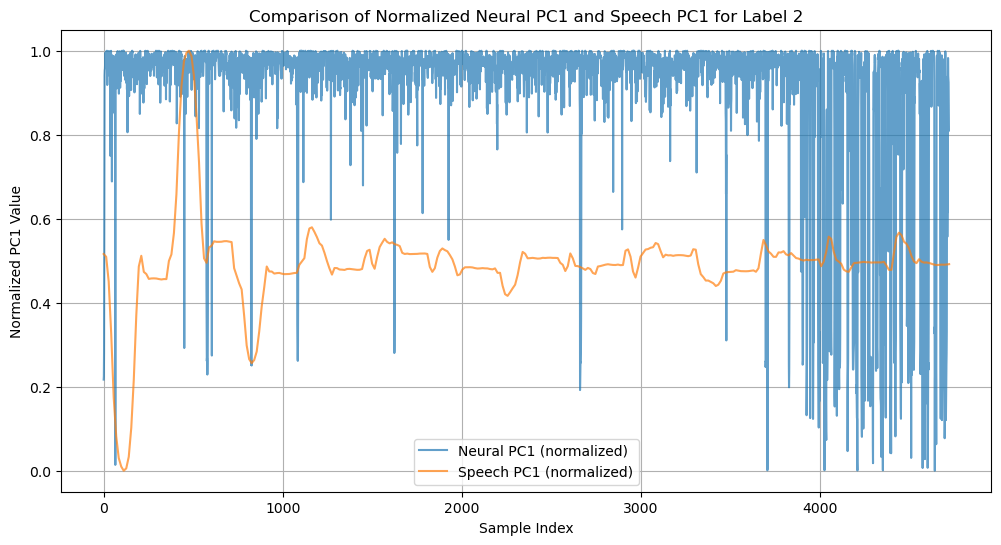

Line plot of normalized Neural PC1 and Speech PC1 for Label 2 has been saved in M:\neuro2voc\task-5\cebra\primaryComponents


In [45]:
import numpy as np
import matplotlib.pyplot as plt

# Print shapes to confirm
print("speechPC1_label_2 shape:", speechPC1_label_2.shape)
print("pc1_label_2 shape:", pc1_label_2.shape)

# Use the minimum length for the scatter plot
min_length = min(len(speechPC1_label_2), len(pc1_label_2))

# Create a scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(pc1_label_2[:min_length], speechPC1_label_2[:min_length], alpha=0.5)
plt.xlabel('Neural PC1')
plt.ylabel('Speech PC1')
plt.title('Neural PC1 vs Speech PC1 for Label 2 (First {} points)'.format(min_length))
plt.grid(True)

# Save the scatter plot
plt.savefig(os.path.join(primary_components_dir, 'neural_vs_speech_pc1_label_2_scatter.png'))
plt.close()

print(f"Scatter plot of Neural PC1 vs Speech PC1 for Label 2 has been saved in {primary_components_dir}")

# Calculate correlation using the minimum length
correlation = np.corrcoef(pc1_label_2[:min_length], speechPC1_label_2[:min_length])[0, 1]
print(f"Correlation between Neural PC1 and Speech PC1 (first {min_length} points): {correlation:.4f}")

# Create line plots to show full trends
# Normalize both to [0, 1] range for comparison
neural_norm = (pc1_label_2 - np.min(pc1_label_2)) / (np.max(pc1_label_2) - np.min(pc1_label_2))
speech_norm = (speechPC1_label_2 - np.min(speechPC1_label_2)) / (np.max(speechPC1_label_2) - np.min(speechPC1_label_2))

plt.figure(figsize=(12, 6))
plt.plot(neural_norm, label='Neural PC1 (normalized)', alpha=0.7)
plt.plot(np.linspace(0, len(neural_norm), len(speech_norm)), speech_norm, label='Speech PC1 (normalized)', alpha=0.7)
plt.xlabel('Sample Index')
plt.ylabel('Normalized PC1 Value')
plt.title('Comparison of Normalized Neural PC1 and Speech PC1 for Label 2')
plt.legend()
plt.grid(True)

# Save the line plot
plt.show()

print(f"Line plot of normalized Neural PC1 and Speech PC1 for Label 2 has been saved in {primary_components_dir}")